In [ ]:
#%pip install --upgrade pip
#%pip install numpy matplotlib
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#%pip install scikit-learn

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------  7.9/8.0 MB 48.7 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 45.1 MB/s  0:00:00
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   - -------------------------------------- 1.8/38.6 MB 8.4 MB/s eta 0:00:05
   --------- ------------------------------ 9.4/38.6 MB 23.5 MB/s eta 0:00:02
   ----------------------- ---------------- 22.3/38.6 MB 37.1 MB/s eta 0:00:01
   ------------------------------- -------- 30.4/38.6 MB 37.1 MB/s eta 0:00:01
   ------------------------------- -------- 30.4/38.6 MB 37.1 MB/s eta 0:00:01
   ---------------------------------------  38.5/38.6 MB 33.1 MB/s eta 0:00:01
   ---------------------------------------- 38.6/38.6 MB 31.0 MB/s  0:00:01

   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [s

In [14]:
# =========================
# 0) Imports + environment
# =========================
import os
import random
import math
import time
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Torch: 2.5.1+cu121


device(type='cuda')

In [15]:
# =========================
# 1) Reproducibility + config
# =========================
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # makes results more deterministic (may slow down a bit)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

@dataclass
class CFG:
    seed: int = 42
    batch_size: int = 128
    num_workers: int = 2
    epochs: int = 5
    lr: float = 1e-3
    weight_decay: float = 1e-4  # L2 regularization
    optimizer: str = "adam"     # "adam" or "sgd"
    momentum: float = 0.9       # for SGD
    use_augmentation: bool = True
    grad_clip_norm: float = 1.0 # set None to disable
    val_split: float = 0.1

cfg = CFG()
seed_everything(cfg.seed)
cfg


CFG(seed=42, batch_size=128, num_workers=2, epochs=5, lr=0.001, weight_decay=0.0001, optimizer='adam', momentum=0.9, use_augmentation=True, grad_clip_norm=1.0, val_split=0.1)

In [16]:
# =========================
# 2) Dataset + transforms
#    - Standardization (normalize)
#    - Data augmentation (optional)
# =========================

# MNIST mean/std commonly used:
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

train_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=10,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ) if cfg.use_augmentation else transforms.Lambda(lambda x: x),
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

train_full = datasets.MNIST(root="./data", train=True, download=True, transform=train_transform)
test_ds    = datasets.MNIST(root="./data", train=False, download=True, transform=test_transform)

val_size = int(len(train_full) * cfg.val_split)
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(cfg.seed))

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(54000, 6000, 10000)

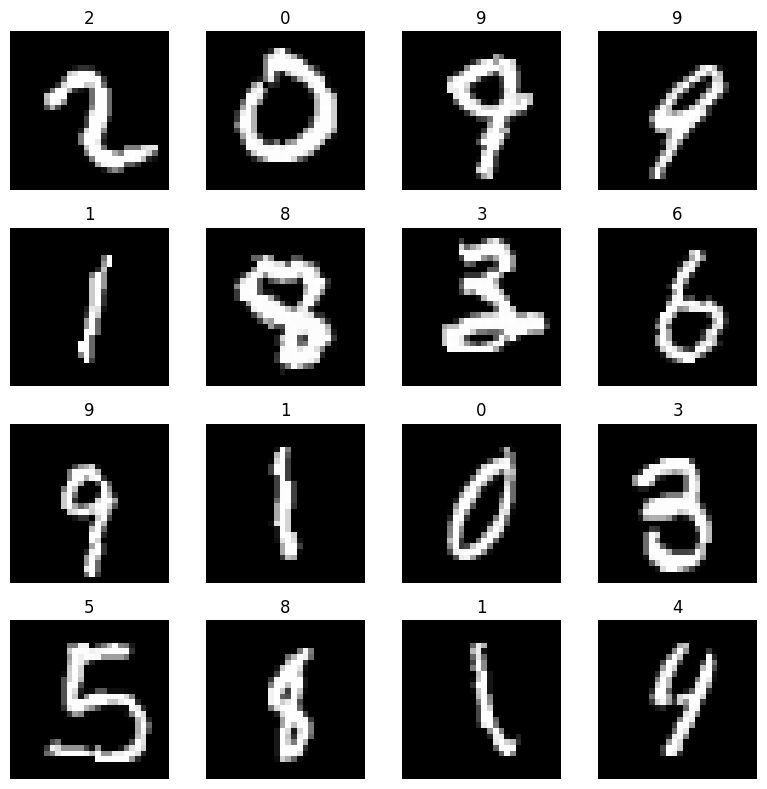

In [17]:
# =========================
# 3) Quick sanity check: visualize a batch
# =========================
def denorm(x):
    # x: (B,1,28,28) normalized
    return x * MNIST_STD + MNIST_MEAN

batch = next(iter(train_loader))
images, labels = batch
images, labels = images[:16], labels[:16]

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(denorm(images[i]).squeeze(0).numpy(), cmap="gray")
    plt.title(int(labels[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()


In [18]:
# =========================
# 4) Models
#    - Baseline MLP (no convolution)
#    - CNN (conv + pooling + dropout + batch norm)
# =========================

class MLPBaseline(nn.Module):
    def __init__(self, hidden=256, dropout=0.2, activation="relu"):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(28*28, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, 10)

        # Weight initialization (He for ReLU, Xavier otherwise)
        if activation.lower() == "relu":
            nn.init.kaiming_normal_(self.fc1.weight)
        else:
            nn.init.xavier_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)

        if self.activation.lower() == "relu":
            x = F.relu(x)
        elif self.activation.lower() == "tanh":
            x = torch.tanh(x)
        elif self.activation.lower() == "sigmoid":
            x = torch.sigmoid(x)
        else:
            raise ValueError("activation must be: relu/tanh/sigmoid")

        x = self.drop(x)
        x = self.fc2(x)  # logits
        return x


class SimpleCNN(nn.Module):
    def __init__(self, dropout=0.25):
        super().__init__()
        # Convolution + BatchNorm + ReLU + Pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.pool  = nn.MaxPool2d(2, 2)  # pooling
        self.drop  = nn.Dropout(dropout)

        # After two poolings: 28->14->7
        self.fc1   = nn.Linear(64 * 7 * 7, 128)
        self.bn3   = nn.BatchNorm1d(128)
        self.fc2   = nn.Linear(128, 10)

        # Weight initialization (He for conv layers with ReLU)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28->14
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14->7
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.drop(x)
        x = self.fc2(x)  # logits
        return x


In [19]:
# =========================
# 5) Training utilities
#    - Cross-entropy loss
#    - Accuracy
#    - Gradient clipping (optional)
# =========================

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    all_preds = []
    all_labels = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

    f1 = f1_score(
        torch.cat(all_labels).numpy(),
        torch.cat(all_preds).numpy(),
        average="macro"
    )
    return total_loss / n, total_acc / n, f1


def make_optimizer(model):
    if cfg.optimizer.lower() == "adam":
        return torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    elif cfg.optimizer.lower() == "sgd":
        return torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
    else:
        raise ValueError("optimizer must be: adam/sgd")

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        if cfg.grad_clip_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.grad_clip_norm)

        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

def f1_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
    y_true = y.detach().cpu().numpy()
    return f1_score(y_true, preds, average="macro")


In [20]:
# =========================
# 6) Full training loop + history
# =========================
def fit(model, train_loader, val_loader, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = make_optimizer(model)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}
    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, epochs+1):
        t0 = time.time()

        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc, va_f1 = evaluate(model, val_loader, criterion)

        history["val_f1"].append(va_f1)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        dt = time.time() - t0
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} | {dt:.1f}s")

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


In [21]:
# =========================
# 7) Train baseline MLP
# =========================
cfg.optimizer = "adam"
cfg.lr = 1e-3
cfg.epochs = 5
cfg.use_augmentation = False  # augmentation is mostly for CNN demonstration

# IMPORTANT: if you change augmentation setting, rebuild train_full/train_ds/train_loader.
# Since we built dataset earlier, keep augmentation fixed for now.

mlp = MLPBaseline(hidden=256, dropout=0.2, activation="relu")
mlp_trained, mlp_hist = fit(mlp, train_loader, val_loader, epochs=cfg.epochs)

mlp_val_loss, mlp_val_acc, mlp_val_f1 = evaluate(mlp_trained, val_loader, nn.CrossEntropyLoss())
mlp_test_loss, mlp_test_acc, mlp_test_f1 = evaluate(mlp_trained, test_loader, nn.CrossEntropyLoss())
mlp_val_acc, mlp_test_acc


Epoch 01/5 | train loss 0.4401 acc 0.8655 | val loss 0.2506 acc 0.9292 f1 0.9284 | 15.8s
Epoch 02/5 | train loss 0.2422 acc 0.9288 | val loss 0.1816 acc 0.9498 f1 0.9494 | 14.2s
Epoch 03/5 | train loss 0.1948 acc 0.9421 | val loss 0.1564 acc 0.9573 f1 0.9570 | 14.7s
Epoch 04/5 | train loss 0.1717 acc 0.9492 | val loss 0.1374 acc 0.9603 f1 0.9597 | 14.4s
Epoch 05/5 | train loss 0.1562 acc 0.9530 | val loss 0.1211 acc 0.9663 f1 0.9659 | 14.5s


(0.9656666673024495, 0.9789)

In [22]:
# =========================
# 8) Train CNN
# =========================
cfg.optimizer = "adam"
cfg.lr = 1e-3
cfg.epochs = 5

cnn = SimpleCNN(dropout=0.25)
cnn_trained, cnn_hist = fit(cnn, train_loader, val_loader, epochs=cfg.epochs)

cnn_val_loss, cnn_val_acc, cnn_val_f1 = evaluate(cnn_trained, val_loader, nn.CrossEntropyLoss())
cnn_test_loss, cnn_test_acc, cnn_test_f1 = evaluate(cnn_trained, test_loader, nn.CrossEntropyLoss())
cnn_val_acc, cnn_test_acc


Epoch 01/5 | train loss 0.2320 acc 0.9309 | val loss 0.0799 acc 0.9757 f1 0.9754 | 15.3s
Epoch 02/5 | train loss 0.0957 acc 0.9707 | val loss 0.0637 acc 0.9798 f1 0.9796 | 17.6s
Epoch 03/5 | train loss 0.0788 acc 0.9760 | val loss 0.0504 acc 0.9843 f1 0.9842 | 18.7s
Epoch 04/5 | train loss 0.0685 acc 0.9786 | val loss 0.0446 acc 0.9862 f1 0.9860 | 19.5s
Epoch 05/5 | train loss 0.0607 acc 0.9812 | val loss 0.0406 acc 0.9880 f1 0.9878 | 18.6s


(0.9875000007947285, 0.9938)

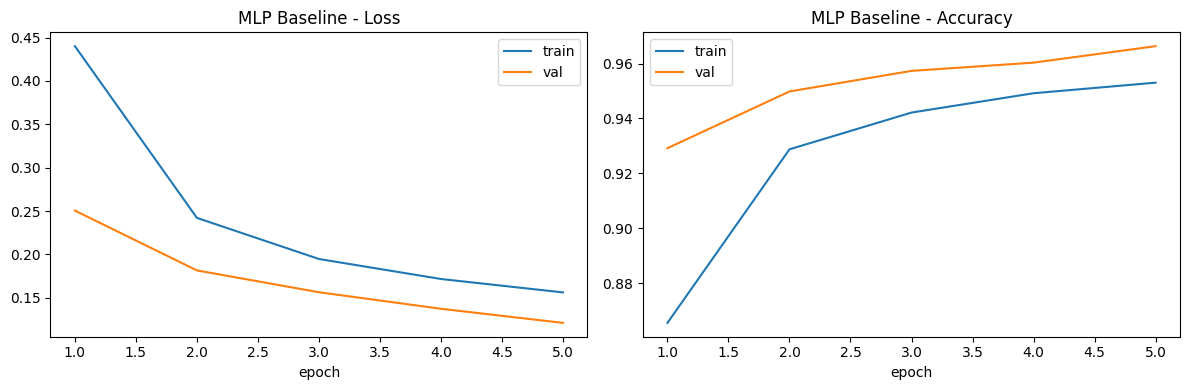

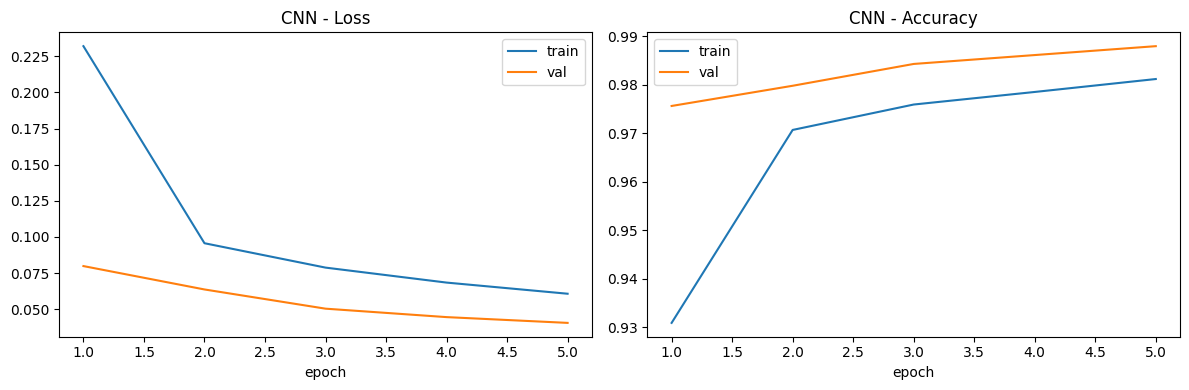

In [23]:
# =========================
# 9) Plot learning curves
# =========================
def plot_history(hist, title):
    epochs = range(1, len(hist["train_loss"])+1)
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(list(epochs), hist["train_loss"], label="train")
    plt.plot(list(epochs), hist["val_loss"], label="val")
    plt.title(f"{title} - Loss")
    plt.xlabel("epoch")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(list(epochs), hist["train_acc"], label="train")
    plt.plot(list(epochs), hist["val_acc"], label="val")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(mlp_hist, "MLP Baseline")
plot_history(cnn_hist, "CNN")


In [24]:
# =========================
# 10) Compare results (quick table)
# =========================
print(f"MLP  : val_acc={mlp_val_acc:.4f} val_f1={mlp_val_f1:.4f} test_acc={mlp_test_acc:.4f} test_f1={mlp_test_f1:.4f}")
print(f"CNN  : val_acc={cnn_val_acc:.4f} val_f1={cnn_val_f1:.4f} test_acc={cnn_test_acc:.4f} test_f1={cnn_test_f1:.4f}")


MLP  : val_acc=0.9657 val_f1=0.9653 test_acc=0.9789 test_f1=0.9788
CNN  : val_acc=0.9875 val_f1=0.9874 test_acc=0.9938 test_f1=0.9938
